In [26]:
from scipy.stats import norm
import numpy as np
import pandas as pd
import re
from collections import Counter
import time
import progressbar
from sklearn.model_selection import train_test_split

df = pd.read_csv('/Users/dashabalashova/python_projects/1_1_5_ML_Bioinf/data/smsspam.csv')
df = df.head(500)
train_df, validate_df = train_test_split(df, test_size=0.2, stratify=df.label)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [27]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()
def stem_f(text2):
    text_words = []
    for w in text2.split():
        text_words.append(ps.stem(w))
    return Counter(text_words)
    
train_df['text2']=train_df.apply(lambda x: re.sub(r'[^\w\s]','',x.text).lower(), axis=1)
train_df['cnt0'] = train_df.apply(lambda x: stem_f(x.text2), axis=1)

validate_df['text2']=validate_df.apply(lambda x: re.sub(r'[^\w\s]','',x.text).lower(), axis=1)
validate_df['cnt0'] = validate_df.apply(lambda x: stem_f(x.text2), axis=1)


In [32]:
all_words = Counter()
for i in range(0,train_df.shape[0]):
    all_words+=train_df.cnt0[i]

words = all_words.keys()
print(len(words))

t=0
n_gr = 3
p_cl = []

for cl in ['ham', 'spam']:
    df_cl = train_df[train_df.label==str(cl)]
    bar = progressbar.ProgressBar().start()
    n_row = df_cl.shape[0]
    p_xi={}
    
    for w in words:
        bar.update(t)
        t+=1
        
        p_xi[w] = [0]*n_gr    
        for n in range(0,n_gr-1):
            p_xi[w][n] = (sum(df_cl.apply(lambda x: x.cnt0[w]==n, axis=1).astype(int))+1)/(n_row+n_gr)
        p_xi[w][n_gr-1] = (sum(df_cl.apply(lambda x: x.cnt0[w]>n_gr-2, axis=1).astype(int))+1)/(n_row+n_gr)

    p_cl.append(p_xi)

dict_spam = {0:'ham', 1:'spam'}

def Multinomial_naive_Bayes(df):
    MNB = []
    n_cl = [sum(df.label=='ham'), sum(df.label=='spam')]
    for i in range(0, df.shape[0]):
        counter_i = df.at[i,'cnt0']
        p_classes = [0, 0]
        for c in [0, 1]:
            p = 1
            for word in counter_i.keys():
                freq = counter_i[word]
                try:
                    p = p * p_cl[c][word][min(freq, n_gr-1)]
                except:
                    #print(word)
                    p = p * 1/(n_cl[c]+n_gr)
            p_classes[c] = p
        MNB.append(p_classes[1]/(p_classes[0]+p_classes[1]))
    return MNB

MNB = Multinomial_naive_Bayes(validate_df)

- | #                                                 | 2 Elapsed Time: 0:00:00

1690


| |          #                                     | 3374 Elapsed Time: 0:00:18

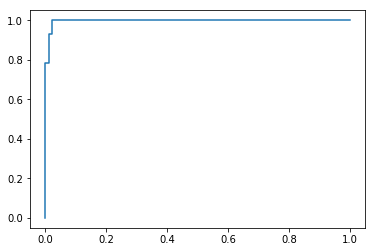

In [34]:
from sklearn import metrics
import matplotlib.pyplot as plt

scores = pd.DataFrame(MNB).fillna(0)
y = validate_df.apply(lambda x: x.label=='spam', axis=1).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y, scores)

plt.plot(fpr, tpr)
plt.show()